Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-4-14194d40ea17>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


  0%|          | 0/54 [00:00<?, ?it/s]<ipython-input-4-14194d40ea17>:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 54/54 [00:10<00:00,  5.37it/s]


Training Loss: 0.6545, Validation Loss: 1.3257
Epoch 2/3


100%|██████████| 54/54 [00:09<00:00,  5.53it/s]


Training Loss: 0.1824, Validation Loss: 0.9607
Epoch 3/3


100%|██████████| 54/54 [00:09<00:00,  5.44it/s]


Training Loss: 0.0768, Validation Loss: 0.9775


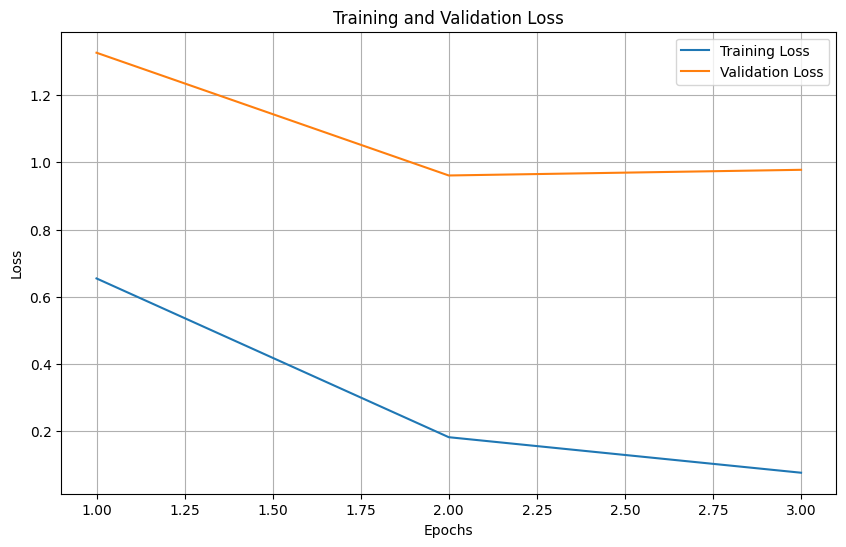

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 10.61it/s]


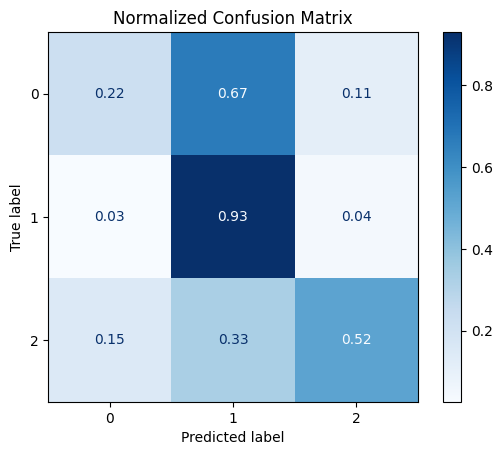

                    precision    recall  f1-score   support

       Hate Speech       0.22      0.22      0.22         9
Offensive Language       0.88      0.93      0.90       114
           Neither       0.70      0.52      0.60        27

          accuracy                           0.81       150
         macro avg       0.60      0.56      0.57       150
      weighted avg       0.81      0.81      0.81       150



In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/new_cleaned_labeled_data_output2.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with Loss Tracking
scaler = GradScaler()
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Tokenize test data
test_encodings = tokenize_data(test_data)

# Create test dataset and dataloader
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Evaluate model on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Hate Speech', 'Offensive Language', 'Neither']))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/7
22/22 [==============================] - 48s 485ms/step - loss: 0.7555 - accuracy: 0.7329 - val_loss: 0.6959 - val_accuracy: 0.7567
Epoch 2/7
22/22 [==============================] - 7s 320ms/step - loss: 0.5938 - accuracy: 0.7786 - val_loss: 0.4201 - val_accuracy: 0.8700
Epoch 3/7
22/22 [==============================] - 7s 342ms/step - loss: 0.4061 - accuracy: 0.8600 - val_loss: 0.4137 - val_accuracy: 0.8767
Epoch 4/7
22/22 [==============================] - 7s 342ms/step - loss: 0.3752 - accuracy: 0.8786 - val_loss: 0.4187 - val_accuracy: 0.8700
Epoch 5/7
22/22 [==============================] - 8s 350ms/step - loss: 0.3482 - accuracy: 0.8943 - val_loss: 0.3910 - val_accuracy: 0.8800
Epoch 6/7
22/22 [==============================] - 8s 347ms/step - loss: 0.2779 - accuracy: 0.9057 - val_loss: 0.4583 - val_accuracy: 0.8700
Epoch 7/7
22/22 [==============================] - 8s 354ms/step - loss: 0.2367 - accuracy: 0.9243 - val_loss: 0.4662 - val_accuracy: 0.8867


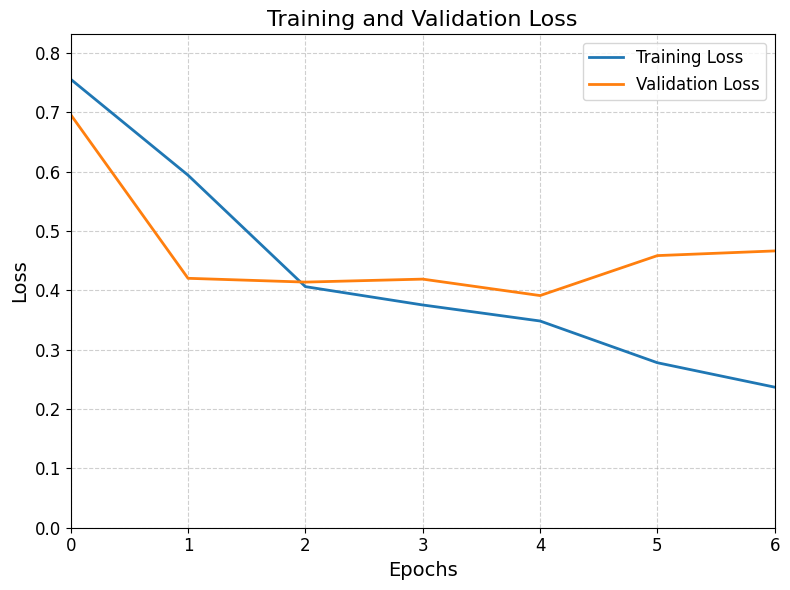

10/10 [==============================] - 4s 84ms/step


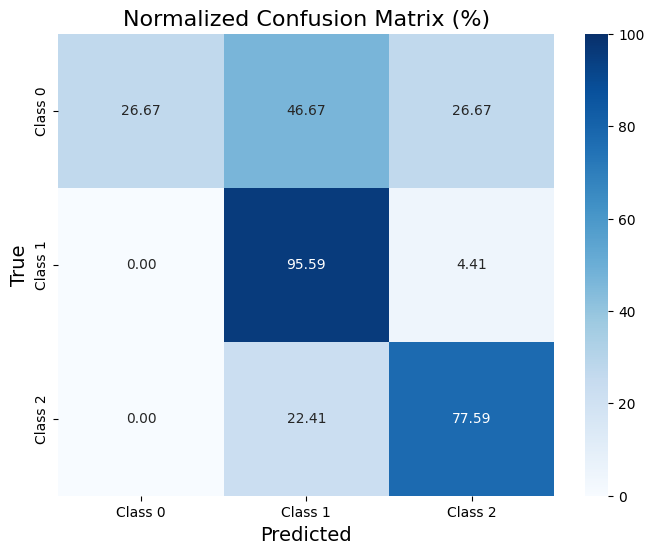

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.27      0.42        15
           1       0.92      0.96      0.94       227
           2       0.76      0.78      0.77        58

    accuracy                           0.89       300
   macro avg       0.89      0.67      0.71       300
weighted avg       0.89      0.89      0.88       300

Accuracy: 88.67%


In [4]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

# Function to load dataset
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

# Function to split dataset
def split_dataset(texts, labels, test_size=0.3, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

# Function to tokenize data
def tokenize_data(tokenizer, texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
    return encodings['input_ids']

# Function to build model
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

# Function to compile model
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Function to train model
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=7, batch_size=32):
    history = model.fit(
        train_input_ids,
        train_labels,
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

# Updated function to plot training and validation loss
def plot_loss_v2(history):
    # Extract loss values
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss', linewidth=2)
    plt.plot(validation_loss, label='Validation Loss', linewidth=2)

    # Format the graph
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  # Add a subtle grid

    # Set consistent axis limits for cleaner visualization
    plt.ylim(0, max(max(training_loss), max(validation_loss)) * 1.1)
    plt.xlim(0, len(training_loss) - 1)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Updated function to evaluate model and plot confusion matrix
def evaluate_model_v2(model, input_ids, true_labels, class_names):
    # Predict and calculate confusion matrix
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    conf_matrix = confusion_matrix(true_labels, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True, vmin=0, vmax=100)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Normalized Confusion Matrix (%)', fontsize=16)
    plt.show()

    # Print additional evaluation metrics
    print("Classification Report:\n", classification_report(true_labels, y_pred))
    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

# Main program
dataset_file = r"/content/drive/MyDrive/new_synonym_replacement.csv"
output_predictions = "test_predictions.csv"

# Load the dataset
text_column = "corrected_tweet"
label_column = "class"
texts, labels = load_dataset(dataset_file, text_column, label_column)

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

# Build and compile the model
num_labels = len(set(labels))
model = build_model('roberta-base', num_labels)
model = compile_model(model)

# Train the model
history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)

# Plot training loss with the updated function
plot_loss_v2(history)

# Evaluate the model and plot confusion matrix
class_names = ["Class 0", "Class 1", "Class 2"]
y_pred = evaluate_model_v2(model, test_input_ids, y_test, class_names)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/7
22/22 [==============================] - 58s 556ms/step - loss: 0.7462 - accuracy: 0.7300 - val_loss: 0.7039 - val_accuracy: 0.7567
Epoch 2/7
22/22 [==============================] - 7s 335ms/step - loss: 0.6949 - accuracy: 0.7643 - val_loss: 0.6795 - val_accuracy: 0.7567
Epoch 3/7
22/22 [==============================] - 8s 345ms/step - loss: 0.6903 - accuracy: 0.7643 - val_loss: 0.6648 - val_accuracy: 0.7567
Epoch 4/7
22/22 [==============================] - 7s 317ms/step - loss: 0.5855 - accuracy: 0.7729 - val_loss: 0.6397 - val_accuracy: 0.7900
Epoch 5/7
22/22 [==============================] - 8s 376ms/step - loss: 0.3880 - accuracy: 0.8786 - val_loss: 0.4825 - val_accuracy: 0.8433
Epoch 6/7
22/22 [==============================] - 7s 324ms/step - loss: 0.3688 - accuracy: 0.8800 - val_loss: 0.3877 - val_accuracy: 0.8800
Epoch 7/7
22/22 [==============================] - 7s 331ms/step - loss: 0.2814 - accuracy: 0.9186 - val_loss: 0.3360 - val_accuracy: 0.8967


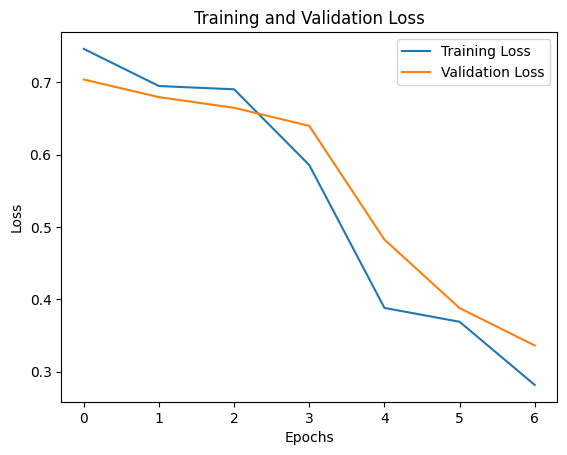

10/10 [==============================] - 4s 92ms/step


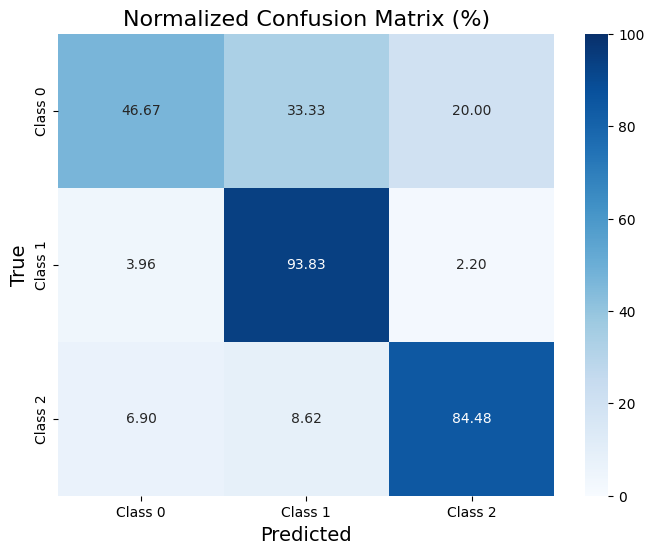

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.47      0.40        15
           1       0.96      0.94      0.95       227
           2       0.86      0.84      0.85        58

    accuracy                           0.90       300
   macro avg       0.72      0.75      0.73       300
weighted avg       0.91      0.90      0.90       300

Accuracy: 89.67%


In [5]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

# Function to load dataset
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

# Function to split dataset
def split_dataset(texts, labels, test_size=0.3, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

# Function to tokenize data
def tokenize_data(tokenizer, texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
    return encodings['input_ids']

# Function to build model
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

# Function to compile model
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Function to train model
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=7, batch_size=32):
    history = model.fit(
        train_input_ids,
        train_labels,
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

# Function to plot training loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Updated function to evaluate model and plot confusion matrix
def evaluate_model_v2(model, input_ids, true_labels, class_names):
    # Predict and calculate confusion matrix
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    conf_matrix = confusion_matrix(true_labels, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True, vmin=0, vmax=100)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Normalized Confusion Matrix (%)', fontsize=16)
    plt.show()

    # Print additional evaluation metrics
    print("Classification Report:\n", classification_report(true_labels, y_pred))
    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

# Main program
dataset_file = r"/content/drive/MyDrive/new_cleaned_labeled_data_output2.csv"
output_predictions = "test_predictions.csv"

# Load the dataset
text_column = "corrected_tweet"
label_column = "class"
texts, labels = load_dataset(dataset_file, text_column, label_column)

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

# Build and compile the model
num_labels = len(set(labels))
model = build_model('roberta-base', num_labels)
model = compile_model(model)

# Train the model
history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)

# Plot training loss
plot_loss(history)

# Evaluate the model and plot confusion matrix
class_names = ["Class 0", "Class 1", "Class 2"]
y_pred = evaluate_model_v2(model, test_input_ids, y_test, class_names)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/7
22/22 [==============================] - 51s 521ms/step - loss: 0.7257 - accuracy: 0.7614 - val_loss: 0.6928 - val_accuracy: 0.7567
Epoch 2/7
22/22 [==============================] - 8s 360ms/step - loss: 0.6894 - accuracy: 0.7643 - val_loss: 0.6706 - val_accuracy: 0.7567
Epoch 3/7
22/22 [==============================] - 8s 357ms/step - loss: 0.6047 - accuracy: 0.7771 - val_loss: 0.5613 - val_accuracy: 0.8100
Epoch 4/7
22/22 [==============================] - 8s 351ms/step - loss: 0.3917 - accuracy: 0.8700 - val_loss: 0.3834 - val_accuracy: 0.8667
Epoch 5/7
22/22 [==============================] - 7s 320ms/step - loss: 0.3042 - accuracy: 0.9100 - val_loss: 0.4000 - val_accuracy: 0.8667
Epoch 6/7
22/22 [==============================] - 8s 347ms/step - loss: 0.2734 - accuracy: 0.9214 - val_loss: 0.4007 - val_accuracy: 0.8733
Epoch 7/7
22/22 [==============================] - 7s 317ms/step - loss: 0.2289 - accuracy: 0.9314 - val_loss: 0.4236 - val_accuracy: 0.8767


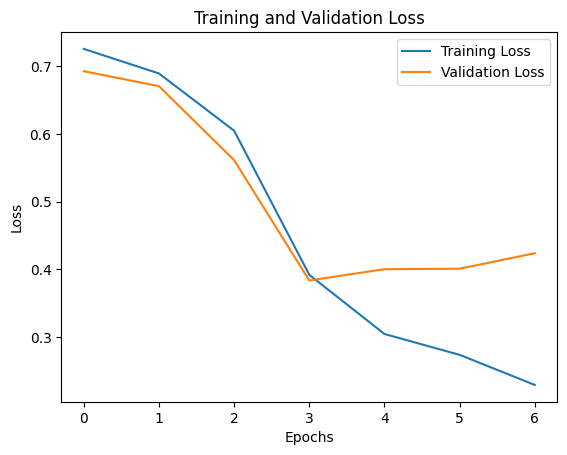

10/10 [==============================] - 4s 81ms/step


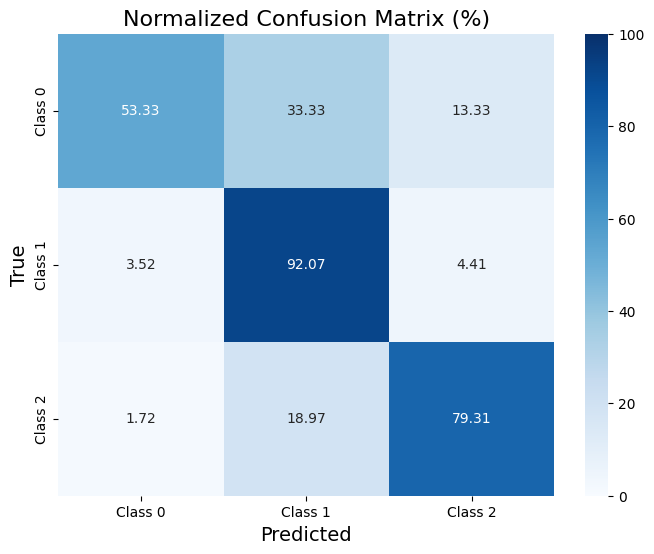

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.93      0.92      0.92       227
           2       0.79      0.79      0.79        58

    accuracy                           0.88       300
   macro avg       0.73      0.75      0.74       300
weighted avg       0.88      0.88      0.88       300

Accuracy: 87.67%


In [6]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

# Function to load dataset
def load_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    texts = df[text_column].values
    labels = df[label_column].values
    return texts, labels

# Function to split dataset
def split_dataset(texts, labels, test_size=0.3, random_state=42):
    return train_test_split(texts, labels, test_size=test_size, random_state=random_state)

# Function to tokenize data
def tokenize_data(tokenizer, texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
    return encodings['input_ids']

# Function to build model
def build_model(pretrained_model_name, num_labels):
    model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
    return model

# Function to compile model
def compile_model(model, learning_rate=5e-5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Function to train model
def train_model(model, train_input_ids, train_labels, val_input_ids, val_labels, epochs=7, batch_size=32):
    history = model.fit(
        train_input_ids,
        train_labels,
        validation_data=(val_input_ids, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

# Function to plot training loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Updated function to evaluate model and plot confusion matrix
def evaluate_model_v2(model, input_ids, true_labels, class_names):
    # Predict and calculate confusion matrix
    y_pred = np.argmax(model.predict(input_ids)[0], axis=1)
    conf_matrix = confusion_matrix(true_labels, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True, vmin=0, vmax=100)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Normalized Confusion Matrix (%)', fontsize=16)
    plt.show()

    # Print additional evaluation metrics
    print("Classification Report:\n", classification_report(true_labels, y_pred))
    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return y_pred

# Main program
dataset_file = r"/content/drive/MyDrive/new_synonym_replacement.csv"
output_predictions = "test_predictions.csv"

# Load the dataset
text_column = "corrected_tweet"
label_column = "class"
texts, labels = load_dataset(dataset_file, text_column, label_column)

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(texts, labels)

# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_input_ids = tokenize_data(tokenizer, X_train)
test_input_ids = tokenize_data(tokenizer, X_test)

# Build and compile the model
num_labels = len(set(labels))
model = build_model('roberta-base', num_labels)
model = compile_model(model)

# Train the model
history = train_model(model, train_input_ids, y_train, test_input_ids, y_test)

# Plot training loss
plot_loss(history)

# Evaluate the model and plot confusion matrix
class_names = ["Class 0", "Class 1", "Class 2"]
y_pred = evaluate_model_v2(model, test_input_ids, y_test, class_names)
